## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne


# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [2]:
def print_graphs(data):
    for i in range(0, 84, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 84, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 84, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [3]:
data = np.load("../dataset/sc/DataSet_A_2/single/data_unificada.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
data = data.swapaxes(2, 1)
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
data.shape

(4, 15360, 21)


(84, 15360)

Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

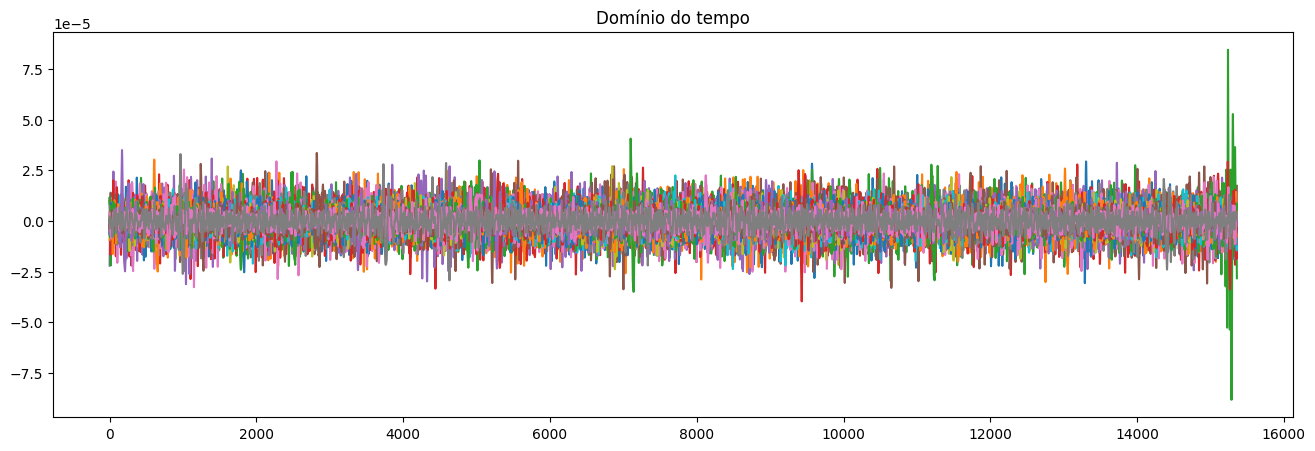

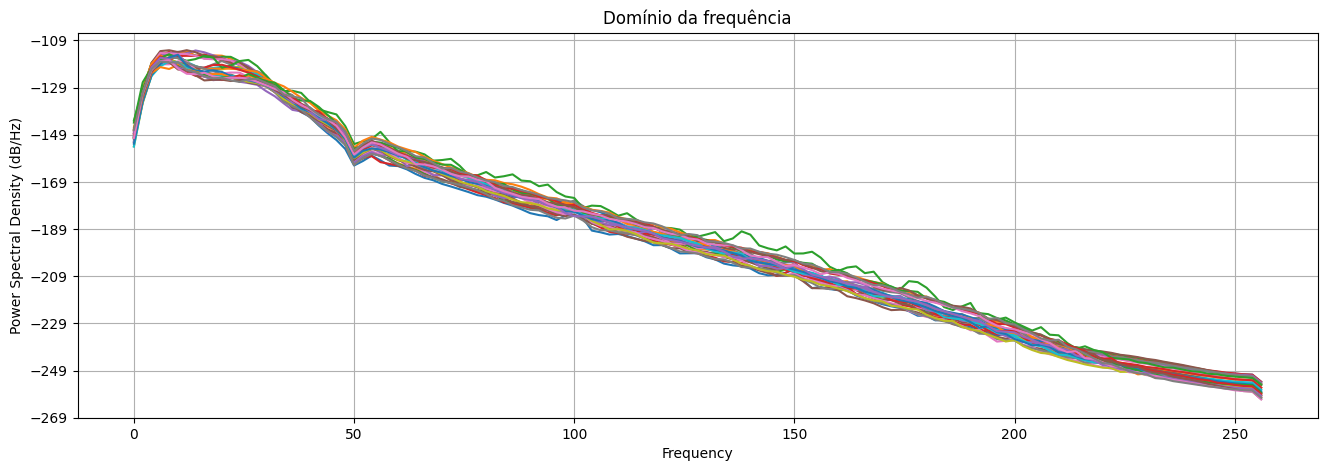

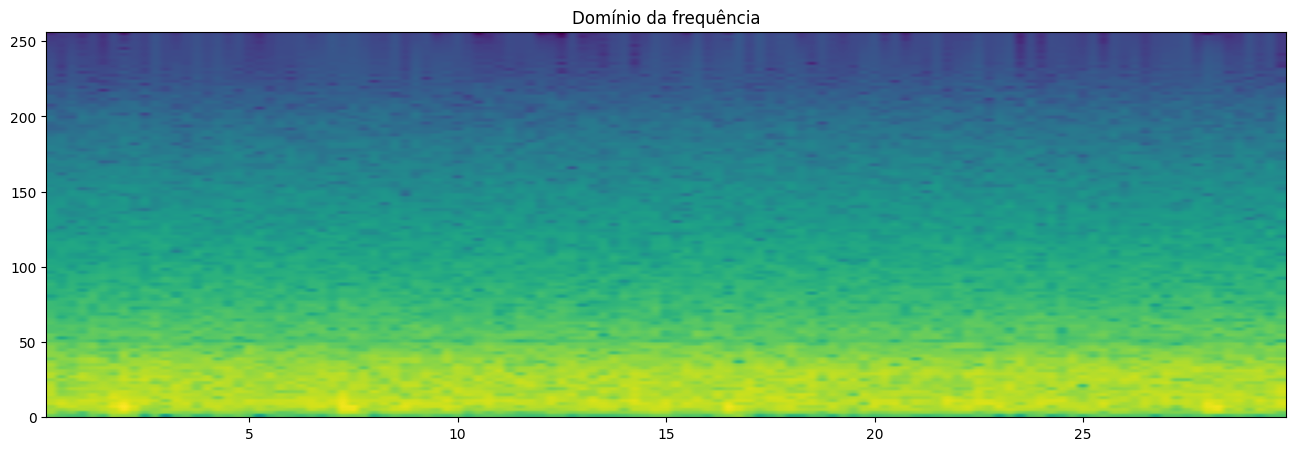

In [4]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [5]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [7]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../dataset/sc/DataSet_A_2/single/label_unificada.npy")
labels = labels.swapaxes(1, 0)
labels = labels.reshape(labels.shape[1] * labels.shape[2])
print(labels, labels.shape)
np.save("../dataset/sc/DataSet_A_2/single/labels_formated.npy", labels)

[10.  10.  10.   6.5  6.5  6.5  6.   6.   6.   7.5  7.5  7.5  7.   7.
  7.   8.2  8.2  8.2  9.3  9.3  9.3 10.  10.  10.   6.5  6.5  6.5  6.
  6.   6.   7.5  7.5  7.5  7.   7.   7.   8.2  8.2  8.2  9.3  9.3  9.3
 10.  10.  10.   6.5  6.5  6.5  6.   6.   6.   7.5  7.5  7.5  7.   7.
  7.   8.2  8.2  8.2  9.3  9.3  9.3 10.  10.  10.   6.5  6.5  6.5  6.
  6.   6.   7.5  7.5  7.5  7.   7.   7.   8.2  8.2  8.2  9.3  9.3  9.3] (84,)


In [8]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data.reshape(data.shape[0], 1, data.shape[1])
# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(labels.shape[0], dtype=int),
    le.fit_transform(labels))
)
event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5, '10':6}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated


Number of events,84
Events,10: 126: 126.5: 127: 127.5: 128.2: 129.3: 12
Time range,0.000 – 29.998 s
Baseline,off


In [ ]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()


# Filtrando e salvando os dados pelo objeto MNE

In [9]:
# aplicando o filtro
mne_data_filtered = mne_data.filter(l_freq=4., h_freq=12)

# salvando os dados
mne_data_filtered.save(fname="../dataset/sc/DataSet_A_2/single/mne_data.fif", overwrite=True)

Setting up band-pass filter from 4 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Overwriting existing file.


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
C:\Users\gregu\AppData\Local\Temp\ipykernel_17336\2134636523.py:5: RuntimeWarning: This filename (../dataset/sc/DataSet_A_2/single/mne_data.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  mne_data_filtered.save(fname="../dataset/sc/DataSet_A_2/single/mne_data.fif", overwrite=True)


# Criação do MNE para o multi target

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [10]:
def print_graphs(data):
    for i in range(0, 100, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 100, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 100, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

In [12]:
data = np.load("../dataset/sc/DataSet_A_2/multi/data_unificada.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
#data = data.swapaxes(2, 1)
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
data.shape

(10, 10, 8192)


(100, 8192)

Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

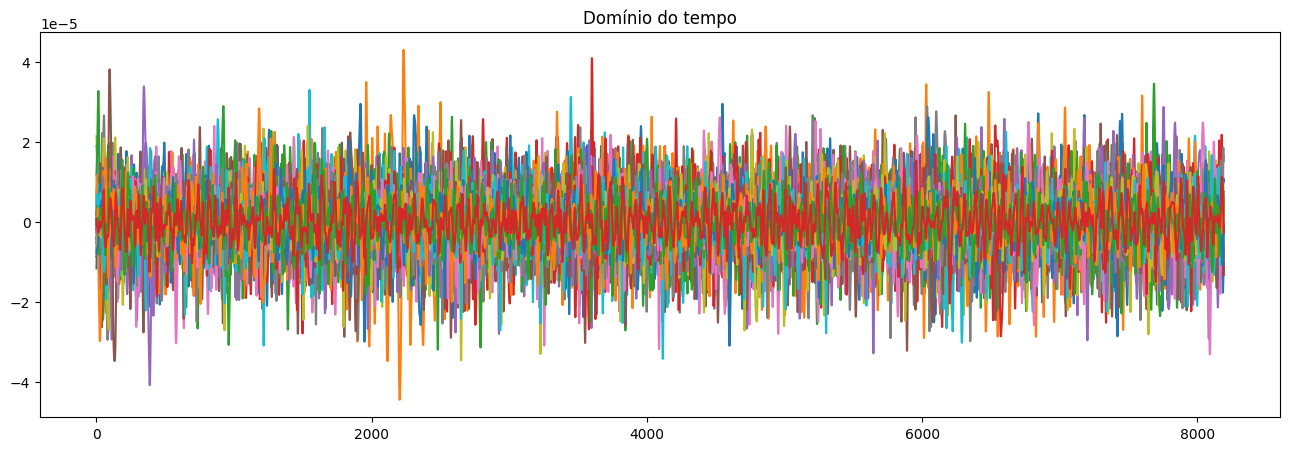

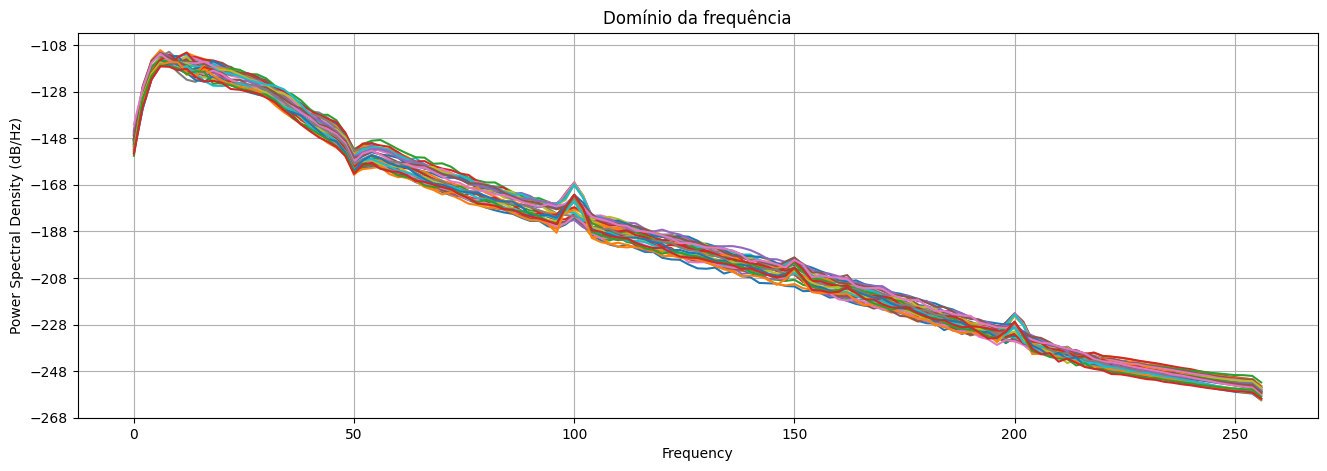

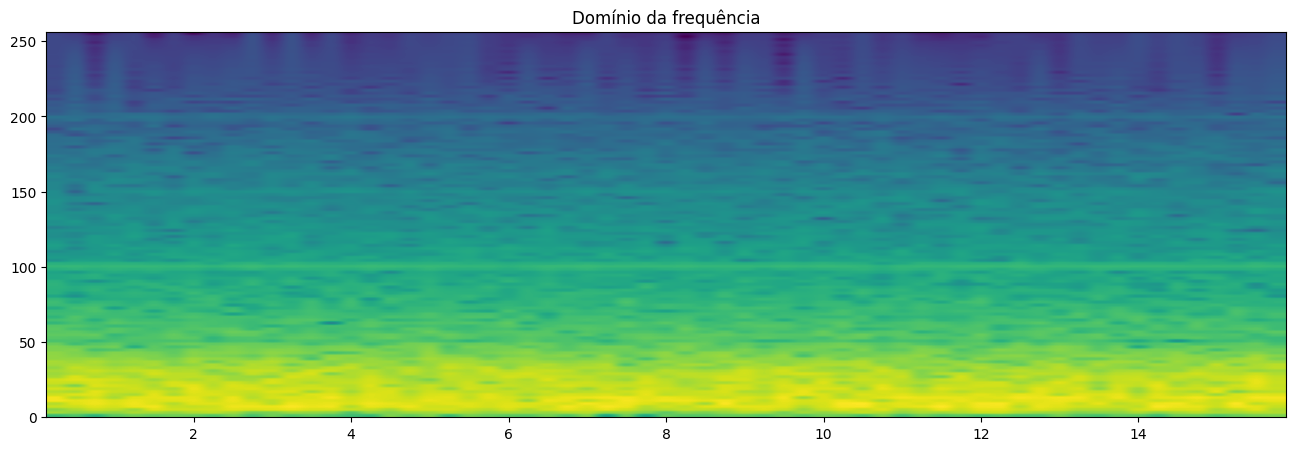

In [13]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [14]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [15]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../dataset/sc/DataSet_A_2/multi/label_unificada.npy")
#labels = labels.swapaxes(1, 0)
labels = labels.reshape(labels.shape[0] * labels.shape[1])
print(labels, labels.shape)
np.save("../dataset/sc/DataSet_A_2/multi/labels_formated.npy", labels)

[7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.  6.  8.2 6.  6.5 7.5 7.
 6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.  6.  8.2 6.  6.5
 7.5 7.  6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.  6.  8.2
 6.  6.5 7.5 7.  6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.
 6.  8.2 6.  6.5 7.5 7.  6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2
 9.3 6.  6.  8.2 6.  6.5 7.5 7.  6.  6. ] (100,)


In [16]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data.reshape(data.shape[0], 1, data.shape[1])
# adicionando label como "épocas" do sinal

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(100, dtype=int),
    le.fit_transform(labels))
)
event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated


Number of events,100
Events,6: 406.5: 57: 107.5: 158.2: 259.3: 5
Time range,0.000 – 15.998 s
Baseline,off


In [ ]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()

# Filtrando e salvandos os dados pelo objeto MNE

In [17]:
# aplicando o filtro
mne_data_filtered = mne_data.filter(l_freq=4., h_freq=12)

# salvando os dados
mne_data_filtered.save(fname="../dataset/sc/DataSet_A_2/multi/mne_data.fif", overwrite=True)

Setting up band-pass filter from 4 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Overwriting existing file.


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
C:\Users\gregu\AppData\Local\Temp\ipykernel_17336\2890484834.py:5: RuntimeWarning: This filename (../dataset/sc/DataSet_A_2/multi/mne_data.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  mne_data_filtered.save(fname="../dataset/sc/DataSet_A_2/multi/mne_data.fif", overwrite=True)


### Tarefas

- Estudar e utilizar os exemplos já apresentados no repositório `tutoriais` e criar o objeto `mne.EpochArray` para os dados *single* e *multi-target* (`AVI dataset`);
- Estudar documentos MNE para realizar a aplicação dos filtros temporais a partir de objetos `mne.EpochArray` (sempre verificando as frequências utilizadas como targets dos `datasets`). Isto também para os dados *single* e *multi-target* (`AVI dataset`);
- **Ótimo**: elaborar toda a aplicação já realizada até o ponto anterior para o *dataset* `Beta`.

# Criação do mne para o beta

In [ ]:
def print_graphs(data):
    for i in range(0, 10, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 10, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 10, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()